### Import libraries

In [1]:
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_timeaxis import __get_timeaxis

In [12]:
def __get_stream(config):
    st = obs.Stream()

    for i in range(len(config.get("sta"))):

        seed = f'{config.get("net")[i]}.{config.get("sta")[i]}.{config.get("loc")}.{config.get("cha")}'

        print(f"loading {seed}...")

        st0, inv = __querrySeismoData(  
                                    seed_id=seed,
                                    starttime=config.get("tbeg"),
                                    endtime=config.get("tend"),
                                    where=config.get("repository"),
                                    path=None,
                                    restitute=True,
                                    detail=None,
                                    fill_value=None,
                                    )
        if len(st0) != 0:
            st += st0
    return st

### Configurations

In [76]:
config = {}

config['tbeg'] = obs.UTCDateTime("2021-09-27 06:17")
config['tend'] = obs.UTCDateTime("2021-09-27 06:45")

config['sta'] = ['GELB','GRMB','BIB','TON', 'ALFT', 'FFB1', 'FFB2', 'FFB3', 'FUR']
config['net'] = ['BW','BW','BW','BW','BW','BW','BW','BW','GR']
config['loc'] = ''
config['cha'] = 'BHZ'

config['repository'] = "jane"

config['event'] = {'t0':'2021-09-27 06:17', 'lat':35.252 , 'lon':25.259}

In [77]:
# from obspy.clients.fdsn import RoutingClient, Client

# route = RoutingClient("eida-routing")
# # route = Client(base_url="http://jane")
# # route = Client("LMU")

# inv = route.get_stations(network=config.get("net")[1], 
#                          station=config.get("sta")[1], 
#                          location=config.get("loc"), 
#                          channel=config.get("cha"),
#                          starttime=config.get("tbeg"),
#                          endtime=config.get("tend"),
#                          level="channel",
#                         );
# inv, inv.get_contents()

In [78]:
st = __get_stream(config)

AttributeError: 'NoneType' object has no attribute 'keys'

### Remove traces with no coordinates

In [79]:
for i, tr in enumerate(st): 
    try: 
        tr.stats.coordinates;
    except:
        st.remove(tr);
        
print(st);

3 Trace(s) in Stream:
BW.FFB1..BHZ   | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:39:59.950000Z | 20.0 Hz, 27600 samples
BW.RLAS..BJZ   | 2021-09-27T06:16:59.982749Z - 2021-09-27T06:39:59.982749Z | 20.0 Hz, 27601 samples
BW.ROMY.10.BJZ | 2021-09-27T06:17:00.008799Z - 2021-09-27T06:40:00.008799Z | 20.0 Hz, 27601 samples


### Add distance to event

In [74]:
from obspy.geodetics import gps2dist_azimuth     

for tr in st:
    tr.stats.distance = gps2dist_azimuth(tr.stats.coordinates.latitude, 
                                         tr.stats.coordinates.longitude,
                                         config.get("event").get("lat"),
                                         config.get("event").get("lon"),
                                        )[0]
st

AttributeError: coordinates

In [18]:
st.remove(st.select(station="BIB")[0])

5 Trace(s) in Stream:
BW.TON..BHZ  | 2021-09-27T06:16:59.997500Z - 2021-09-27T06:44:59.997500Z | 20.0 Hz, 33601 samples
BW.FFB1..BHZ | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:45:00.000000Z | 40.0 Hz, 67201 samples
BW.FFB2..BHZ | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:45:00.000000Z | 40.0 Hz, 67201 samples
BW.FFB3..BHZ | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:45:00.000000Z | 40.0 Hz, 67201 samples
GR.FUR..BHZ  | 2021-09-27T06:16:59.990000Z - 2021-09-27T06:44:59.990000Z | 20.0 Hz, 33601 samples

### Plotting

In [75]:
fig = plt.figure(figsize=(15,8))
st.plot(type="section", 
#         dist_degree=True, 
#         ev_coord=(config.get("event").get("lat"),config.get("event").get("lon")),
        norm_method='stream',
        time_down=True,
        show=False,
        fig=fig,
        );

from matplotlib.transforms import blended_transform_factory

ax = fig.axes[0]
transform = blended_transform_factory(ax.transData, ax.transAxes)
for tr in st:
    ax.text(tr.stats.distance / 1e3, 1.0, tr.stats.station, rotation=270,
            va="bottom", ha="center", transform=transform, zorder=10)
plt.show();

ValueError: trace.stats.distance undefined (set before plotting [in m], or use the ev_coords argument)

<Figure size 1080x576 with 0 Axes>

## Compare RLAS, ROMY-Z, ADR and FFB1

### Configurations

In [70]:
config2 = {}

config2['tbeg'] = obs.UTCDateTime("2021-09-27 06:17")
config2['tend'] = obs.UTCDateTime("2021-09-27 06:40")

config2['seeds'] = {#'FUR': 'GR.FUR..BHZ',
                    'FFB1':'BW.FFB1..BHZ', 
                    'RLAS':'BW.RLAS..BJZ', 
                    'ROMY':'BW.ROMY.10.BJZ', 
                    'ADRZ':'BW.ROMY.20.BSZ',
                   }

config2['filter'] = {'type':'bandpass', 'fmin': 0.01, 'fmax': 0.2}

config2['repository'] = ["online", "online", "archive", "archive", "archive"]

### Load data

In [71]:
def __get_stream(config):
    
    st = obs.Stream()

    for i, seed in enumerate(config.get("seeds").keys()):

        seed = config.get("seeds")[seed]

        print(f"loading {seed}...")

        st0, inv = __querrySeismoData(  
                                    seed_id=seed,
                                    starttime=config.get("tbeg"),
                                    endtime=config.get("tend"),
                                    where=config.get("repository")[i],
                                    path=None,
                                    restitute=True,
                                    detail=None,
                                    fill_value=None,
                                    )
        if st0[0].stats.channel == "BSZ":
            st0[0].stats.station ="ADRZ"
        if len(st0) != 0:
            st += st0
    return st

st0 = __get_stream(config2)

loading BW.FFB1..BHZ...
loading BW.RLAS..BJZ...


/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/core/inventory/response.py:1193: UserWarning: The unit 'RAD/S' is not known to ObsPy. It will be assumed to be displacement for the calculations. This mostly does the right thing but please proceed with caution.
  warnings.warn(msg)


loading BW.ROMY.10.BJZ...
loading BW.ROMY.20.BSZ...
No matching channel metadata found.


### Processing

In [72]:
st = st0.copy();

st.trim(starttime=config2.get("tbeg"), endtime=config2.get("tend"));

st.detrend('demean');

for tr in st:
    if tr.stats.sampling_rate > 20:
        tr.resample(20);
        
if config2['filter']:
    st.filter(config2['filter']['type'], 
              freqmin=config2['filter']['fmin'],
              freqmax=config2['filter']['fmax'], 
              corners=4, 
              zerophase=True);
print(st);

4 Trace(s) in Stream:
BW.FFB1..BHZ   | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:39:59.950000Z | 20.0 Hz, 27600 samples
BW.RLAS..BJZ   | 2021-09-27T06:16:59.982749Z - 2021-09-27T06:39:59.982749Z | 20.0 Hz, 27601 samples
BW.ROMY.10.BJZ | 2021-09-27T06:17:00.008799Z - 2021-09-27T06:40:00.008799Z | 20.0 Hz, 27601 samples
BW.ADRZ.20.BSZ | 2021-09-27T06:17:00.000000Z - 2021-09-27T06:40:00.000000Z | 20.0 Hz, 27601 samples


/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


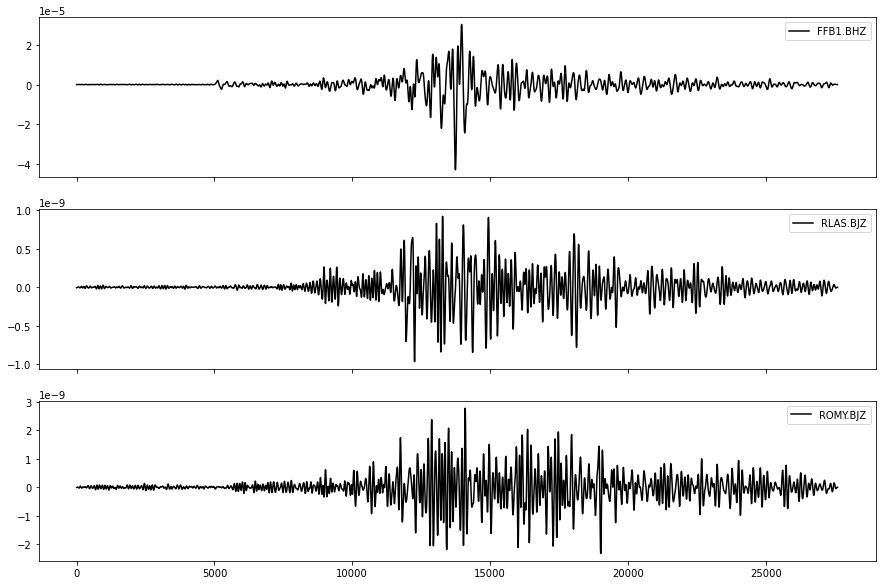

In [80]:
fig, ax = plt.subplots(len(st),1, figsize=(15,10), sharex=True)

for i, tr in enumerate(st):
    ax[i].plot(tr.data, color='k', label=f'{tr.stats.station}.{tr.stats.channel}');
    ax[i].legend(loc="upper right")
    
fig.show();